***
** Algorithmes d'optimisation -- L3 MINT et doubles licences 2017/2018 -- Université Paris-Sud **
***

# TP 2: Descente de gradient avec recherche linéaire

$\newcommand{\Rsp}{\mathbb{R}}
\newcommand{\nr}[1]{\|#1\|}
\newcommand{\abs}[1]{|#1|}
\newcommand{\eps}{\varepsilon}
\newcommand{\sca}[2]{\langle#1|#2\rangle}
\newcommand{\D}{\mathrm{D}}
\newcommand{\hdots}{\dots}
\newcommand{\cond}{\mathrm{cond}}$

Étant donné un couple $(x,d)$ le pas d'Armijo est défini de la manière suivante: 

$$ t^{arm}(x,d) = \max \left\{ t  \mid t = \beta^k, k\in \mathbb{N}, \hbox{ tq } f(x + tv) \leq f(x) + \alpha t\sca{\nabla f(x)}{d} \right\}, $$

où $\beta \in ]0,1[$, $\alpha \in ]0,\frac{1}{2}[$. En pratique, on prendra souvent $\alpha = 0.3, \beta = 0.5$. Algorithmiquement, on procède de la manière suivante pour trouver $t = t^{arm}(x,d)$: 
$$
\left|
\begin{aligned}
&t \gets 1\\
&m \gets \sca{\nabla f(x)}{d}\\
&\textbf{while } f(x + t v) > f(x) + \alpha t m \\
&\qquad t \gets \beta t
\end{aligned}\right.
$$

L'algorithme de descente de gradient avec backtracking d'Armijo s'écrit alors de la manière suivante:

$$
\begin{cases}
d^{(k)} = - \nabla f(x^{(k)} \\
t^{(k)} = t(x^{(k)}, d^{(k)})\\
x^{(k+1} = x^{k} + t^{(k)} d^{(k)}
\end{cases}$$

L'objectif de ce TP est 1) d'implémenter cet algorithme, 2) de le comparer à la descente de gradient à pas optimal et 3) de l'appliquer à des problèmes d'optimisation de dimension élevée, provenant du traitement du signal et d'images. En particulier, on verra qu'il n'est pas particulièrement difficile de résoudre un problème quadratique de dimension $\simeq 250000$ dès lors que la matrice SDP définissant le problème est bien conditionnée.

# III Implémentation de l'algorithme

L'algorithme du gradient à pas optimal demande de savoir calculer de manière exacte le minimum de $f(x+td)$. Ceci est rarement faisable (sauf dans le cas où $f$ est quadratique). Il est donc utile d'avoir une autre méthode permettant de choisir le pas de manière automatique: on appelle ce problème la "recherche linéaire" car on travaille sur la (demi-)droite $\{x + td \mid t\geq 0\}$. Il existe de nombreuses approches pour la recherche linéaire, nous présentons l'algorithme de "backtracking" d'Armijo, qui est simple à programmer et à analyser mathématiquement.

**QIII.1**)  Écrire une fonction `backtrack` prenant en entrée $f:\Rsp^N\to\Rsp$, $x,d\in\Rsp^N$ et $m = \sca{\nabla f(x)}{d}$, et retournant le pas $t$. 

Tester la fonction `backtrack` dans le cas $N=1$, $f(x) = x^{2} + e^{-x}$, $x_0 = 1$ et en arrêtant l'algorithme dès que $\nr{d^{(k)}} \leq 10^{-8}$. Vous devriez trouver $x^* = -0.3517...$. Comparer le nombre d'itérations pour $\alpha=0.3$ et $\beta$ variant entre $0.1$ et $0.9$.

In [1]:
# on importe les modules numpy et pyplot
import numpy as np
import matplotlib.pyplot as plt
# les deux commandes suivante paramètrent l'affichage des figures
%matplotlib inline
plt.rcParams['figure.figsize'] = [9.,6.]

# les paramètres alpha et beta comportent une valeur par défaut, c'est-à-dire que 
# backtrack(f,x,d,m) est équivalent à backtrack(f,x,d,m,0.3,0.5)
def backtrack(f,x,d,m,alpha=0.3,beta=0.5):
    t = 1
    while f(x+t*d) > f(x) + alpha*t*m:
        t = beta*t
    return t

# test de la fonction backtracking
f = lambda x: x**2 + np.exp(x)
g = lambda x: 2*x + np.exp(x)

for i in range(1,10):
    x = 1.
    k = 0
    while(True):
        k = k+1
        d = - g(x)
        if np.linalg.norm(d) < 1e-8:
            break
        beta = float(i)/10
        t = backtrack(f,x,d,-d*d, 0.3, beta)
        x = x + t*d
    print('nombre d\'itérations pour beta = %g: %d' % (beta, k))


nombre d'itérations pour beta = 0.1: 66
nombre d'itérations pour beta = 0.2: 26
nombre d'itérations pour beta = 0.3: 14
nombre d'itérations pour beta = 0.4: 10
nombre d'itérations pour beta = 0.5: 19
nombre d'itérations pour beta = 0.6: 9
nombre d'itérations pour beta = 0.7: 18
nombre d'itérations pour beta = 0.8: 20
nombre d'itérations pour beta = 0.9: 22


**QIII.2**) Écrire une fonction `gradient_backtracking` prenant en argument la fonction $f$, $g = \nabla f$ (c'est-à-dire une deuxième fonction telle que $g(x) = \nabla f(x)$), $x_0$ et un critère d'arrêt `err`, et qui effectue l'algorithme de descente de gradient avec backtracking en arrêtant la boucle dès que $\nr{d^{(k)}} \leq$ `err`. Cette fonction retournera le point $x$ trouvé, un vecteur contenant $f(x^{(k)})$ et un second vecteur contenant $\nr{d^{(k)}}$. 

Tester la fonction avec les $f$ et $g$ donnés ci-dessous (on notera la notation **lambda** permettant de définir une fonction en une seule ligne):

In [2]:
# la descente de gradient prend en argument:
# f = la fonction à évaluer
# g = le gradient de f
# x0 = le point de départ
def gradient_backtracking(f,g,x0,err=1e-6):
    x = x0
    E = []
    F = []
    k = 0 # nombre d'itérations
    while(True): 
        k = k+1
        if k > 1e6: # maximum de 10^6 itérations
            print('erreur: nombre maximum d\'itérations atteint')
            break
        # calcul de d, t, 
        d = -g(x)
        F.append(f(x))
        E.append(np.linalg.norm(d))
        if np.linalg.norm(d) <= err:
            break
        t = backtrack(f,x,d,-np.linalg.norm(d)**2)
        x = x + t*d
    return x,np.array(E),np.array(F)

# on rappelle la fonction gradient_optimal du TP précédent, 
# permettant de minimiser f(x) = .5*<x|Qx> + <b|x>,
def gradient_optimal(Q,b,x0,err=1e-6):
    x = x0
    niter=0
    E = []
    F = []
    
    k = 0 # nombre d'itérations
    while (True): 
        k = k+1
        if k > 1e6: # maximum de 10^6 itérations
            print('erreur: nombre maximum d\'itérations atteint')
            break
        # calculer la direction de descente
        d = -(np.dot(Q,x)+b)
        E.append(np.linalg.norm(d))
        F.append(.5*np.dot(x,np.dot(Q,x)) + np.dot(b,x))
        # vérifier le critère d'arrêt, et quitter la boucle (avec break) s'il est vérifié
        if np.linalg.norm(d) <= err:
            break
        # calculer le pas de descente et mettre à jour x
        t = np.linalg.norm(d)**2/np.dot(np.dot(Q,d), d)
        x = x + t*d
    E = np.array(E)
    F = np.array(F)
    return x,E,F

# on teste avec la fonction de la partie I. Ci-dessous, on utilise la 
# notation lambda pour définir des fonctions sur une seule ligne, ce qui
# est parfois utile.
K = 10.
f = lambda x: .5*(K*x[0]**2 + x[1]**2)
g = lambda x: np.array([K*x[0], x[1]])

# Appliquer l'algorithme du gradient avec backtracking
# puis comparer le nombre d'itérations avec le gradient à pas optimal
x,E,F = gradient_backtracking(f,g,np.array([1.,K]))
print('nombre d\'itérations gradient avec backtracking', len(E))

Q = np.array([[K, 0],[0,1]])
b = np.zeros(2)
x,E,F = gradient_optimal(Q,b,np.array([1.,K]))
print('nombre d\'itérations gradient à pas optimal:', len(E))


nombre d'itérations gradient avec backtracking 60
nombre d'itérations gradient à pas optimal: 84


# IV Application: débruitage de signal 

On propose une application: on se donne un signal $1D$, encodé sous la forme d'un vecteur $y_1,\hdots,y_{N}$, par exemple $y_i = sin(2 i \pi/N)$. On suppose que notre signal a été modifié par l'addition d'une (petite) composante aléatoire à chacune de ses entrées, de la manière suivante:

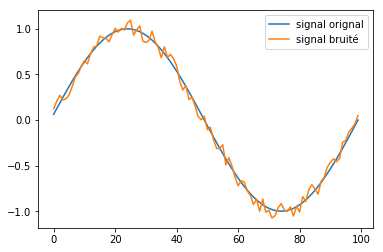

In [3]:
N=100
y = np.sin(2*np.linspace(1.,N,N)*np.pi/N)
p1, = plt.plot(y,label='signal orignal')
y = y + .2*(np.random.rand(N)-.5)
p2, = plt.plot(y,label='signal bruité')
plt.legend()

On voit bien que la particularité du signal bruité est la présence de 'sauts' entre deux composantes successives $y_i$ et $y_{i+1}$. On va chercher à débruiter signal $y$ en résolvant le problème d'optimisation suivant

$$ \inf_{x\in \Rsp^N} f(x) := \frac{1}{2} \nr{x - y}^2 +  \frac{K}{2}\sum_{1\leq i\leq N} (x_{i+1} - x_i)^2, $$

où l'on a défini $x_{N+1} := x_1$.
Le minimiseur $x^*$ de ce problème offrira un compromis entre deux aspects. Le premier terme de $f$ demande à ce que $x^*$ soit près du signal donné en entrée, $y$. Le deuxième terme est grand lorsque les entrées de $x$ varient rapidement, et incite donc $x^*$ à varier lentement. Cela aura l'effet de gommer les sauts (le bruit) ajouté à $y$. On pourrait dire beaucoup de chose sur ce modèle (dans la direction des statistiques ou dans celles des équations aux dérivées partielles), mais ici on le considère comme un problème d'optimisation à résoudre numériquement.

**QIV.1** Démontrer que le problème d'optimisation admet une solution. Montrer que la fonction $f$ est convexe et vérifie $D^2 f(x) \geq 1$. Calculer le gradient de $f$.

**Réponse:** 
Pour montrer l'existence d'un minimum on va montrer que la fonction $f$ est convexe et coercive. Pour la coercivité (c'est à dire que $f(x) \to +\infty$ quand $\|x \|  \to +\infty$)
on remarque que $\frac{K}{2}\sum_{1\leq i\leq N} (x_{i+1} - x_i)^2\geq 0$ et donc, par inégalité triangulaire, $f(x)\geq \frac{1}{2} \nr{x - y}^2\geq \frac{1}{2} \nr{x}^2-\frac{1}{2} \nr{ y}^2 \to +\infty$ quand $\|x \|  \to +\infty$. 

Pour la convexité : on sait que $x \mapsto \frac{1}{2} \nr{x - y}^2$ est convexe (on peut vérifier par exemple que sa Hessienne est la matrice $Id$). Comme la somme de fonctions convexes est convexe il suffit de verifier que pour i fixé, $ h_i : x \mapsto (x_{i+1} - x_i)^2$ est convexe. 
Pour cela on considère un $0<t<1, x,z \in \Rsp^n$ et on utilise la convexité de la fonction de $\Rsp\to \Rsp : u\to u^2$ : 

\begin{equation}
h_i((1-t)x+tz)= ((1-t)(x_{i+1}-x_{i}) + t( z_{i+1}-z_i))^2\leq (1-t)(x_{i+1}-x_{i})^2 + t( z_{i+1}-z_i)^2 \leq (1-t)h_i(x) + th_i(z).
\end{equation}

On peut toute de suite en déduire que la hessienne de $\frac{K}{2}\sum_{1\leq i\leq N} (x_{i+1} - x_i)^2 $ est positive (par convexité) et donc que $D^2 f(x) \geq  D^2 \left[x\to \frac{1}{2} \nr{x - y}^2\right] = Id$.

Pour le gradient de $f$ on a d'une part $\nabla \left[x\to \frac{1}{2} \nr{x - y}^2\right]= x-y$ et d'autre part 

$$
\frac{\partial}{\partial_{x_l}} \frac{K}{2}\sum_{1\leq i\leq N} (x_{i+1} - x_i)^2 
= -K  (x_{l+1} - x_l)+ K(x_{l} - x_{l-1}) =K(-x_{l+1} + 2x_l- x_{l-1}) 
$$

donc 

$$
\nabla f(x) = x-y + K\left( -np.roll(x,1)+2x -np.roll(x,-1)\right).
$$


**QIV.2** Écrire deux fonctions $f$ et $g$, telles que $g(x) = \nabla f(x)$. On évitera au maximum les boucles: par exemple, on pourra utiliser $np.roll(x,1)$ pour décaler cycliquement les éléments de $x$ de $1$ vers la droite. On testera le calcul de $g$ via la fonction `check_gradient` proposée ci-dessous:

In [4]:
f = lambda x,K: .5*np.sum((x-y)**2) + .5*K*np.sum((np.roll(x,1)-x)**2)
g = lambda x,K: (x-y) + K*(2*x-np.roll(x,1)-np.roll(x,-1))

# vérifie que g calcule bien le gradient de $f$ en comparant à un calcul par différence finies
def check_gradient(f,g,x0):
    N = len(x0)
    gg = np.zeros(N)
    for i in range(N):
        eps = 1e-5
        e = np.zeros(N)
        e[i] = eps
        gg[i] = (f(x0+e) - f(x0-e))/(2*eps)
    print('erreur numérique dans le calcul du gradient: %g (doit être petit)' % np.linalg.norm(g(x0)-gg))

check_gradient(lambda x: f(x,0.1), lambda x: g(x,0.1), np.random.rand(N))

erreur numérique dans le calcul du gradient: 2.17889e-09 (doit être petit)


**QIV.3** Tester l'algorithme de descente de gradient avec backtracking sur ce problème, et tracer les solutions obtenues lorsqu'on fait varier $K \in \{0.5, 2, 10, 50\}$.

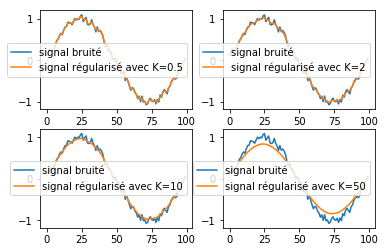

In [5]:
i = 1
for K in [0.5,2.,10,50]:
    x,E,F = gradient_backtracking(lambda x: f(x,K), lambda x: g(x,K),y)
    plt.subplot(2,2,i); i = i+1
    plt.plot(y,label='signal bruité')
    plt.plot(x,label='signal régularisé avec K=%g' % K)
    plt.legend()


**QIV.4** Montrer que la fonction $f$ peut être mise sous la forme $f(x) = \frac{1}{2} x^T Q x + b^T x + c$, où 
$Q = K A^T A + \mathrm{Id}$ où $A$ est la matrice circulante 

$$ A = \begin{pmatrix}  -1 & 1 & 0 & \dots  & 0 \\
       0 & -1 & 1  & \dots &  0  \\
       \vdots &\ddots & \ddots & \ddots &\vdots \\
        0 & \hdots & \hdots & -1  & 1\\
        1 & 0 & \hdots & 0 & -1 
\end{pmatrix}$$

Vérifier numériquement qu'à $K$ fixé (par exemple $K=10$), le conditionnement dépend très peu de la dimension $N$. Vérifier également que le nombre d'itérations de l'algorithme dépend très peu de la dimension du problème en prenant $N=10,100,1000$.

**Réponse:** 
Le premier terme de $f$ est facile a développer : 
$$\frac{1}{2} \nr{x - y}^2 = \frac{1}{2} x^Tx+\frac{1}{2}y^Ty -x^Ty.$$
Pour le second terme de $f$ on remarque que 
$\frac{K}{2}\sum_{1\leq i\leq N} (x_{i+1} - x_i)^2 = Kz^Tz $ avec $z_i = (x_{i+1} - x_i)$. Il suffit allors de trouver une matrice $A$ telle que $Ax=z$, et la matrice proposée convient. On obtient alors  $c=\frac{1}{2}y^Ty$ et $b =-y$.



In [6]:
import scipy.linalg
K = 10
for N in [10,100,1000]: 
    e = np.zeros(N)
    e[0] = -1
    e[1] = 1
    A = scipy.linalg.circulant(e).T
    Q = np.dot(A.T,A)
    print('conditionnement pour N=%d: %g' % (N,np.linalg.cond(K*Q + np.eye(N))))

for N in [10,100,1000]:
    f = lambda x: .5*np.sum((x-y)**2) + .5*K*np.sum((np.roll(x,1)-x)**2)
    g = lambda x: (x-y) + K*(2*x-np.roll(x,1)-np.roll(x,-1))
    y = np.sin(2*np.linspace(1.,N,N)*np.pi/N)
    y = y + .2*(np.random.rand(N)-.5)
    x,E,F = gradient_backtracking(f,g,y)
    print('nombre d\'itérations pour N=%d: %d' % (N,len(E)))


conditionnement pour N=10: 41
conditionnement pour N=100: 41
conditionnement pour N=1000: 41
nombre d'itérations pour N=10: 43
nombre d'itérations pour N=100: 127
nombre d'itérations pour N=1000: 130


**QIV.5** En utilisant le théorème de Gerschgorin, qui est rappelé ci-dessous, démontrer que si $\lambda_1\leq \hdots\leq \lambda_N$ sont les valeurs propres de $Q$, alors 
$$ 1 \leq \lambda_1 \leq \lambda_N \leq 4K+1, $$
de sorte que $\cond(Q) \leq 4K+1$.


**Théorème de Gerschgorin**: Soit $A = (A_{ij})_{1\leq i,j\leq N}$ une matrice carrée et $\lambda$ une valeur propre de $A$. Alors, il existe $i \in \{1,\hdots,N\}$ tel que 
$$ \abs{\lambda - A_{ii}} \leq \sum_{j\neq i} \abs{A_{ij}}. $$

**Réponse:** 
Ici il suffit d'utiliser l'inégalité triangulaire dans le sens "soustraction" (rappel : pour tout $a,b$ réels : $|a|-|b|\leq| a-b|$). 

Tout d'abord on remarque que pour tout $i,j$
$$
{Q_{ij}} = \delta{i=j}+ K\sum^N_{k=1} A^T_{ik}A_{kj}=\delta{i=j}+ K\sum^N_{k=1} A_{ki}A_{kj}
$$
puisque $A_ki = -\delta_{k,i}+\delta_{k,i-1}$ (où $\delta_{i,j}$ est le symbole de Kronecker, i.e. $\delta_{ij} = 1$ si $i=j$ et $0$ sinon) on trouve ${Q_{ii}}=2K+1$, ${Q_{i(i-1)}}= {Q_{(i-1)i}}  = -K$ et ${Q_{ij}}=0$ sinon. 
En utilisant le théorème de Gerschgorin pour $\lambda_N$ et $Q$ on obtient qu'il exite un $i$ tel que 
$$ \abs{\lambda_N - Q_{ii}} \leq \sum_{j\neq i} \abs{Q_{ij}}$$
par inégalité triangulaire, avec $\lambda_N =a$, on trouve $\abs{\lambda_N - Q_{ii}}\geq \lambda_N - \abs{ Q_{ii}} $ donc 
$$
\lambda_N \leq \sum_{j\neq i} \abs{Q_{ij}} + \abs{ Q_{ii}}\leq 2K+ 2K+1=4K+1
$$
De même l'inégalité triangulaire, avec $\lambda_1=b$, donne $\abs{\lambda_1 - Q_{ii}}\geq \abs{ Q_{ii}} - \lambda_1  $ et donc via Gerschgorin, il existe $i$ tel que 
$$
\lambda_1 \geq \abs{ Q_{ii}}- \sum_{j\neq i} \abs{Q_{ij}} \geq 2K+1-2K=1.
$$

On en déduit  $cond(Q) \leq \frac{\lambda_N}{\lambda_1} \leq 4K+1$


# V Application: débruitage d'images

La méthode présentée au paragraphe précédent n'est pas cantonée aux signaux $1$-dimensionnels. On considère une image en niveaux de gris de taille $n\times n$ comme une matrice $(x_{ij})_{1\leq i, j\leq n} \in M_N(\Rsp)$, où $x_{ij}$ représente l'intensité du pixel $(i,j)$. Notre image source $y$ est définie de la manière suivante:

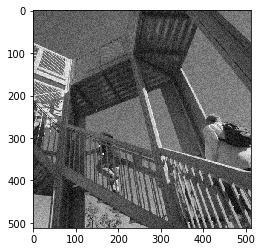

In [7]:
import scipy.misc
n = 512
y = 1.0-scipy.misc.ascent().astype(float)/255.0
y = y + .2*np.random.rand(n,n) # on rajoute un bruit aléatoire à l'image
plt.imshow(y, cmap = plt.cm.binary)

Comme précédemment, on va chercher à débruiter l'image par une méthode d'optimisation (on parle de *traitement variationnel des images*): 

$$ \min_{x\in M_N(\Rsp)} f(x) := \frac{1}{2} \nr{x - y}^2 +  \frac{K}{2}\sum_{1\leq i,j\leq N} (x_{i+1,j} - x_{i,j})^2 + (x_{i,j+1} - x_{i,j})^2, $$

où $\nr{z}^2 = \sum_{1\leq i,j\leq n} z_{ij}^2$ est la norme canonique sur l'espace des matrices $M_N(\Rsp) \simeq \Rsp^{N\times N}$. Comme dans la partie prédente, on prends comme convention que $x_{i,N+1} = x_{i,1}$ et $x_{N+1,j} = x_{1,j}$. Le problème de minimisation cherche un compromis entre la proximité de $x^*$ à $y$ (car le premier terme explose lorsque $x$ s'éloigne de $y$) et la "régularité" de l'image reconstruite $x^*$ (car le second terme explose lorsque les valeurs de pixels adjacents sont très différentes).

**QV.1** Appliquer l'algorithme de descente de gradient avec backtracking à ce problème, avec $K=4$ et en prenant comme critère d'arrêt `err=1e-4`. On pourra admettre dans un premier temps que 

$$ \partial_{x_ij} f(x) = x_{ij} - y_{ij} + K*(4 x_{i,j} - x_{i-1,j} - x_{i+1,j} - x_{i,j-1} - x_{i,j+1}). $$

On utilisera la fonction `np.roll`, qui fonctionne aussi pour des tableaux 2D pour calculer $f$ et son gradient. 


**QV.2** Montrer que $f(x) = \frac{1}{2} \nr{x-y}^2 + \frac{K}{2} \sca{x}{\Phi(x)}$  où $\sca{\cdot}{\cdot}$ est le produit scalaire induit par la norme euclidienne choisie sur $M_{N}(\Rsp)$ et où $\Phi: M_N(\Rsp)\to M_N(\Rsp)$ est l'application linéaire définie par 
$\Phi(x)_{ij} = 4 x_{i,j} - x_{i-1,j} - x_{i+1,j} - x_{i,j-1} - x_{i,j+1}$

**QV.2** En utilisant le théorème de Gerschgorin, en déduire que le conditionnement de la Hessienne de $f$ est borné par $8K+1$.


nombre d'itérations 91


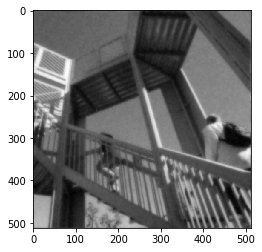

In [8]:
K = 4
f = lambda x: .5*K*np.sum((np.roll(x,1,0) - x)**2+(np.roll(x,1,1) - x)**2) + .5*np.sum((x-y)**2)
g = lambda x: K*(4*x-np.roll(x,1,0)-np.roll(x,-1,0) - np.roll(x,1,1) - np.roll(x,-1,1)) + (x-y)

x,gv,fv = gradient_backtracking(f, g, np.zeros((n,n)), err=1e-4)
print('nombre d\'itérations', len(fv))
plt.imshow(x, cmap = plt.cm.binary)
